# 1) YOLO Architecture

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import json
import time
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [33]:
class RadarDataset(Dataset):
    def __init__(self, image_dir, label_dir, S=7, B=2, C=11):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.S = S
        self.B = B
        self.C = C
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, '*.png')))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = os.path.join(self.label_dir, os.path.basename(image_path).replace('.png', '.txt'))

        image = Image.open(image_path)
        image = self.transform(image)

        label_matrix = torch.zeros((self.S, self.S, self.B * 5 + self.C), dtype=torch.float32)

        # lablel_matrix -> [7,7,21]
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    cls, x, y, w, h = map(float, line.strip().split())
                    i = min(int(self.S * y), self.S - 1)
                    j = min(int(self.S * x), self.S - 1)
                    x_cell, y_cell = self.S * x - j, self.S * y - i

                    if label_matrix[i, j, 4] == 0: 
                        label_matrix[i, j, 4] = 1 
                        label_matrix[i, j, 0:4] = torch.tensor([x_cell, y_cell, w, h])
                        class_start_index = self.B * 5
                        label_matrix[i, j, class_start_index + int(cls)] = 1

        return image, label_matrix


In [34]:
class YOLOv1(nn.Module):
    def __init__(self, S=7, B=2, C=11):
        super(YOLOv1, self).__init__()
        self.S = S
        self.B = B
        self.C = C

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(192, 128, kernel_size=1), nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=1), nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, S * S * (C + B * 5))
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x.view(-1, self.S, self.S, self.B * 5 + self.C) ## -1 makes the .view automatically tak4es the batch size 

# 2) YOLO Loss

In [35]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=11, lambda_coord=5, lambda_noobj=0.5):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='sum')
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    def forward(self, predictions, target):
        N = predictions.shape[0]
        obj_mask = target[..., 4] > 0
        noobj_mask = target[..., 4] == 0

        coord_loss = 0
        obj_conf_loss = 0
        noobj_conf_loss = 0 
        class_loss = 0

        for b in range(N):
            for i in range(self.S):
                for j in range(self.S):
                    # OBJECT LOSS 
                    if obj_mask[b, i, j]:
                        iou1 = iou(predictions[b, i, j, 0:4].unsqueeze(0), target[b, i, j, 0:4].unsqueeze(0))
                        iou2 = iou(predictions[b, i, j, 5:9].unsqueeze(0), target[b, i, j, 0:4].unsqueeze(0))

                        if iou1 >= iou2:
                            responsible_box_preds = predictions[b, i, j, 0:5]
                            other_box_conf_pred = predictions[b, i, j, 9] 
                        else:
                            responsible_box_preds = predictions[b, i, j, 5:10]
                            other_box_conf_pred = predictions[b, i, j, 4] 
                        
                        gt_box = target[b, i, j, 0:5]

                        # Coordinate loss 
                        responsible_box_preds_wh_sqrt = torch.sign(responsible_box_preds[2:4]) * torch.sqrt(torch.abs(responsible_box_preds[2:4] + 1e-6))
                        gt_box_wh_sqrt = torch.sqrt(gt_box[2:4])
                        coord_loss += self.lambda_coord * (self.mse(responsible_box_preds[:2], gt_box[:2]) + self.mse(responsible_box_preds_wh_sqrt, gt_box_wh_sqrt))
                        
                        # Object confidence loss 
                        obj_conf_loss += self.mse(responsible_box_preds[4:5], torch.ones_like(responsible_box_preds[4:5]))

                        # No-object confidence loss 
                        noobj_conf_loss += self.lambda_noobj * self.mse(other_box_conf_pred.unsqueeze(0), torch.zeros_like(other_box_conf_pred.unsqueeze(0)))
                        ## needs to fix this, thhis loss part could alsoo occur where an obkect is not present 
                        # could also do noobj_conf_loss += self.lambda_noobj * self.mse(predictions[b, i, j, [4, 9]], torch.zeros(2))
                        # Classification loss
                        class_loss += self.mse(predictions[b, i, j, self.B*5:], target[b, i, j, self.B*5:])

        noobj_conf_preds = predictions[noobj_mask][..., [4, 9]]
        noobj_conf_targets = torch.zeros_like(noobj_conf_preds)
        noobj_conf_loss += self.lambda_noobj * self.mse(noobj_conf_preds, noobj_conf_targets)

        total_loss = (coord_loss + obj_conf_loss + noobj_conf_loss + class_loss) / N
        return total_loss

# 3) IOU function

In [36]:
def iou(boxes1, boxes2):
    # Convert from (x, y, w, h) to (x1, y1, x2, y2)
    boxes1_x1 = boxes1[..., 0] - boxes1[..., 2] / 2
    boxes1_y1 = boxes1[..., 1] - boxes1[..., 3] / 2
    boxes1_x2 = boxes1[..., 0] + boxes1[..., 2] / 2
    boxes1_y2 = boxes1[..., 1] + boxes1[..., 3] / 2

    boxes2_x1 = boxes2[..., 0] - boxes2[..., 2] / 2
    boxes2_y1 = boxes2[..., 1] - boxes2[..., 3] / 2
    boxes2_x2 = boxes2[..., 0] + boxes2[..., 2] / 2
    boxes2_y2 = boxes2[..., 1] + boxes2[..., 3] / 2

    inter_x1 = torch.max(boxes1_x1, boxes2_x1)
    inter_y1 = torch.max(boxes1_y1, boxes2_y1)
    inter_x2 = torch.min(boxes1_x2, boxes2_x2)
    inter_y2 = torch.min(boxes1_y2, boxes2_y2)

    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)  ## clamp to make the non overlapping area to become 0 instead of negative

    area1 = (boxes1_x2 - boxes1_x1) * (boxes1_y2 - boxes1_y1)
    area2 = (boxes2_x2 - boxes2_x1) * (boxes2_y2 - boxes2_y1)

    union = area1 + area2 - inter_area + 1e-6  ## to avoid division by zero
    return inter_area / union


In [37]:
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    if inter_area == 0:
        return 0.0
    box1_area = max(0, (box1[2] - box1[0])) * max(0, (box1[3] - box1[1]))
    box2_area = max(0, (box2[2] - box2[0])) * max(0, (box2[3] - box2[1]))
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0.0

In [38]:
def average_iou_correct(predictions, ground_truths, iou_threshold=0.5):
    total_iou = 0.0
    matched_count = 0

    gt_by_image = {}
    for gt in ground_truths:
        img_id = gt[0]
        gt_by_image.setdefault(img_id, []).append(gt)

    for pred in predictions:
        img_id, cls_id, conf, x1, y1, x2, y2 = pred
        pred_box = [x1, y1, x2, y2]
        if img_id not in gt_by_image:
            continue

        best_iou = 0
        best_gt = None
        for gt in gt_by_image[img_id]:
            gt_cls, gx1, gy1, gx2, gy2 = gt[1:]
            if gt_cls != cls_id:
                continue
            iou = calculate_iou(pred_box, [gx1, gy1, gx2, gy2])
            if iou > best_iou:
                best_iou = iou
                best_gt = gt

        if best_gt and best_iou >= iou_threshold:
            total_iou += best_iou
            matched_count += 1

    avg_iou = total_iou / matched_count if matched_count > 0 else 0.0
    return avg_iou

# ->> With COCO map

## 4) NMS Function

changing iou_threshold from 0.5 to 0.2

In [39]:
## Without NMS: YOLO would output dozens of overlapping boxes for the same object. -> COCO evaluation would treat them as false positives, because only the best-matching one counts → mAP would drop drastically.
## With NMS: Only the best boxes survive, so detections are cleaner and interpretable.

def nms(boxes, iou_thresh=0.5):
    boxes = sorted(boxes, key=lambda x: x[1], reverse=True)
    keep = []
    while boxes:
        best = boxes.pop(0)
        keep.append(best)
        boxes = [b for b in boxes if iou(
            torch.tensor(b[2:]), torch.tensor(best[2:])) < iou_thresh]
    return keep

# it keeps the boxes with highest CF and IOU less than threshold becuase the latter one might be a bounding box for a different object and we want to keep it


In [40]:
'''This function converts YOLO’s raw grid predictions into actual bounding boxes. \
It adjusts coordinates from cell-relative to image-relative, filters low-confidence boxes, 
assigns class labels, and finally applies NMS to remove duplicates — returning the 
final detections for each image.'''

def decode_predictions(preds, S=7, B=2, C=11, conf_thresh=0.1):
    batch_size = preds.shape[0]
    decoded = []

    for b in range(batch_size):
        boxes = []
        pred = preds[b]
        for i in range(S):
            for j in range(S):
                for b_idx in range(B):
                    offset = b_idx * 5
                    conf = pred[i, j, offset + 4]
                    if conf > conf_thresh:
                        x = (pred[i, j, offset + 0] + j) / S
                        y = (pred[i, j, offset + 1] + i) / S
                        w = pred[i, j, offset + 2]
                        h = pred[i, j, offset + 3]
                        cls = torch.argmax(pred[i, j, B * 5:]).item()
                        boxes.append([cls, conf.item(), x.item(), y.item(), w.item(), h.item()])
        decoded.append(nms(boxes))
    return decoded


In [41]:
def compute_average_iou_for_dataset(model, loader, device, iou_threshold=0.5):

    model.eval()
    predictions, ground_truths = [], []
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(tqdm(loader, desc="Computing Avg IoU")):
            imgs = imgs.to(device)
            preds = model(imgs).cpu()
            decoded_preds = decode_predictions(preds, conf_thresh=0.2)

            # Loop over each image in batch
            for img_idx, label in enumerate(labels):
                img_global_id = batch_idx * loader.batch_size + img_idx

                # --- Collect ground truths ---
                for row in range(label.shape[0]):
                    for col in range(label.shape[1]):
                        if label[row, col, 4] > 0:
                            cls_id = torch.argmax(label[row, col, 10:]).item()  # class
                            x = (label[row, col, 0] + col) / 7  # cell to image
                            y = (label[row, col, 1] + row) / 7
                            w, h = label[row, col, 2], label[row, col, 3]
                            x1, y1 = x - w / 2, y - h / 2
                            x2, y2 = x + w / 2, y + h / 2
                            ground_truths.append([img_global_id, cls_id, x1, y1, x2, y2])

                # --- Collect predictions ---
                if decoded_preds[img_idx]:
                    for box in decoded_preds[img_idx]:
                        cls, conf, x, y, w, h = box
                        x1, y1 = x - w / 2, y - h / 2
                        x2, y2 = x + w / 2, y + h / 2
                        predictions.append([img_global_id, cls, conf, x1, y1, x2, y2])

    # Compute Average IoU
    avg_iou = average_iou_correct(predictions, ground_truths, iou_threshold)
    return avg_iou


# ->> Without the COCO map, Scratch mAP

## 4) NMS function

In [42]:
import math
from collections import Counter

def nms_v1(boxes, iou_thresh=0.5):
    # boxes: list of [cls, conf, x, y, w, h] (normalized center format)
    if not boxes:
        return []
    boxes = sorted(boxes, key=lambda x: x[1], reverse=True)
    keep = []
    while boxes:
        best = boxes.pop(0)
        keep.append(best)
        boxes = [b for b in boxes if iou(torch.tensor(b[2:]), torch.tensor(best[2:])) < iou_thresh]
    return keep

## Get pred boxes

In [43]:
def get_all_bboxes_v1(loader, model, device, conf_thresh=0.1, iou_thresh=0.5, img_size=128):
    model.eval()
    all_pred_boxes = []
    with torch.no_grad():
        for batch_idx, (imgs, _) in enumerate(tqdm(loader, desc="Collecting preds")):
            imgs = imgs.to(device)
            preds = model(imgs).cpu()
            # Use keyword for conf_thresh to avoid being interpreted as S
            decoded = decode_predictions(preds, conf_thresh=conf_thresh)  # returns per-image list of [cls, conf, x,y,w,h]
            for i, boxes in enumerate(decoded):
                global_idx = batch_idx * loader.batch_size + i
                # apply nms per-image
                boxes = nms_v1(boxes, iou_thresh=iou_thresh)
                for b in boxes:
                    cls, conf, x, y, w, h = b
                    # convert to xyxy in pixel coords
                    x1 = (x - w/2) * img_size
                    y1 = (y - h/2) * img_size
                    x2 = (x + w/2) * img_size
                    y2 = (y + h/2) * img_size
                    all_pred_boxes.append([global_idx, int(cls), float(conf), float(x1), float(y1), float(x2), float(y2)])
    model.train()
    return all_pred_boxes

## Get GT boxes

In [44]:
def get_all_ground_truths_v1(loader, img_size=128):
    # returns list of [img_idx, cls, x1,y1,x2,y2]
    all_gts = []
    # Use loader.dataset to iterate in same order
    dataset = loader.dataset
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        for row in range(label.shape[0]):
            for col in range(label.shape[1]):
                if label[row, col, 4] > 0:
                    cls = torch.argmax(label[row, col, 10:]).item() if label.shape[2] > 10 else int(label[row, col, -1].item()) if label.shape[2] >= 11 else 0
                    x = (label[row, col, 0] + col) / dataset.S
                    y = (label[row, col, 1] + row) / dataset.S
                    w = label[row, col, 2].item()
                    h = label[row, col, 3].item()
                    x1 = (x - w/2) * img_size
                    y1 = (y - h/2) * img_size
                    x2 = (x + w/2) * img_size
                    y2 = (y + h/2) * img_size
                    all_gts.append([idx, int(cls), float(x1), float(y1), float(x2), float(y2)])
    return all_gts

## Scratch mAP

In [45]:
def mean_average_precision_v1(pred_boxes, true_boxes, iou_threshold=0.5, num_classes=11):
    """
    pred_boxes: list of [img_idx, cls, conf, x1,y1,x2,y2]
    true_boxes: list of [img_idx, cls, x1,y1,x2,y2]
    """
    average_precisions = []

    for c in range(num_classes):
        detections = [d for d in pred_boxes if d[1] == c]
        gts = [g for g in true_boxes if g[1] == c]

        amount_bboxes = Counter([g[0] for g in gts])
        # create matched flags per-image
        gt_matched = {}
        for img_id, count in amount_bboxes.items():
            gt_matched[img_id] = torch.zeros(count)

        # sort detections by confidence
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros(len(detections))
        FP = torch.zeros(len(detections))
        total_true_bboxes = len(gts)
        if total_true_bboxes == 0:
            continue

        for det_idx, det in enumerate(detections):
            img_id = det[0]
            det_box = det[3:]  # x1,y1,x2,y2
            # get all gts for that image
            gts_img = [g for g in gts if g[0] == img_id]
            best_iou = 0
            best_gt_idx = -1
            for gt_idx, gt in enumerate(gts_img):
                iou_val = calculate_iou(det_box, gt[2:])  # uses existing calculate_iou (xyxy)
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_gt_idx = gt_idx
            if best_iou >= iou_threshold and best_gt_idx != -1:
                # find global gt index position among this image gts for matched mask
                # build index mapping
                # count how many gts before this gt in gts list for the image
                # We need to know position of this gt among image's gts to index gt_matched
                # Recompute: build list of gts for image to map
                img_gts_list = [g for g in gts if g[0] == img_id]
                # position of matched gt among img_gts_list
                # find first gt whose coords match the chosen gt (match by values)
                matched_pos = None
                for pos, gg in enumerate(img_gts_list):
                    if (abs(gg[2] - gts_img[best_gt_idx][2]) < 1e-6 and
                        abs(gg[3] - gts_img[best_gt_idx][3]) < 1e-6 and
                        abs(gg[4] - gts_img[best_gt_idx][4]) < 1e-6 and
                        abs(gg[5] - gts_img[best_gt_idx][5]) < 1e-6):
                        matched_pos = pos
                        break
                if matched_pos is None:
                    FP[det_idx] = 1
                else:
                    if img_id in gt_matched and gt_matched[img_id][matched_pos] == 0:
                        TP[det_idx] = 1
                        gt_matched[img_id][matched_pos] = 1
                    else:
                        FP[det_idx] = 1
            else:
                FP[det_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)

        recalls = TP_cumsum / (total_true_bboxes + 1e-6)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + 1e-6)

        # add boundary points for integration
        precisions = torch.cat((torch.tensor([1.0]), precisions))
        recalls = torch.cat((torch.tensor([0.0]), recalls))

        # approximate area under PR curve
        ap = torch.trapz(precisions, recalls).item()
        average_precisions.append(ap)

    if len(average_precisions) == 0:
        return 0.0
    return sum(average_precisions) / len(average_precisions)

# 5) Evaluate function

## older function

In [12]:
'''This function runs inference on the dataset, decodes YOLO predictions into bounding boxes, 
formats ground truth and predictions into COCO JSON, and 
finally evaluates model accuracy using COCO’s mAP metrics, while also reporting inference speed.'''


# def evaluate(model, loader, device, class_names, image_dir, label_dir):
#     model.eval()
#     all_preds = {}
#     start = time.time()

#     with torch.no_grad():
#         for i, (imgs, _) in enumerate(tqdm(loader, desc='Evaluating')):
#             imgs = imgs.to(device)
#             preds = model(imgs).cpu()
#             decoded = decode_predictions(preds)
            
#             for j in range(imgs.size(0)):
#                 global_idx = i * loader.batch_size + j
#                 all_preds[global_idx] = decoded[j]

#     end = time.time()
#     print(f"\nInference Speed: {len(loader.dataset)/(end-start):.2f} FPS")

#     coco_images, coco_annotations, ann_id = [], [], 1
#     img_files = sorted(glob.glob(os.path.join(image_dir, '*.png')))
    
#     for img_id, img_path in enumerate(img_files):
#         file_name = os.path.basename(img_path)
#         coco_images.append({
#             "id": img_id,
#             "file_name": file_name,
#             "width": 128,
#             "height": 128
#         })

#         label_path = os.path.join(label_dir, file_name.replace('.png', '.txt'))
#         if os.path.exists(label_path):
#             with open(label_path, 'r') as f:
#                 for line in f:
#                     cls, x, y, w, h = map(float, line.strip().split())
#                     x_min = (x - w / 2) * 128
#                     y_min = (y - h / 2) * 128
#                     coco_annotations.append({
#                         "id": ann_id,
#                         "image_id": img_id,
#                         "category_id": int(cls),
#                         "bbox": [x_min, y_min, w * 128, h * 128],
#                         "area": w * 128 * h * 128,
#                         "iscrowd": 0
#                     })
#                     ann_id += 1


#     categories = [{"id": i, "name": name, "supercategory": "none"} for i, name in enumerate(class_names)]

#     gt_json = {
#         "info": {
#             "description": "Radar Dataset",
#             "version": "1.0",
#             "year": 2025,
#             "contributor": "YourName",
#             "date_created": time.strftime("%Y-%m-%d %H:%M:%S")
#         },
#         "images": coco_images,
#         "annotations": coco_annotations,
#         "categories": categories
#     }

#     with open("ground_truth.json", 'w') as f:
#         json.dump(gt_json, f, indent=2)

#     pred_json = []
#     for img_id, preds in all_preds.items():
#         for pred in preds:
#             cls, conf, x, y, w, h = pred
#             x_min = (x - w / 2) * 128
#             y_min = (y - h / 2) * 128
#             pred_json.append({
#                 "image_id": img_id,
#                 "category_id": int(cls),
#                 "bbox": [x_min, y_min, w * 128, h * 128],
#                 "score": float(conf)
#             })

#     with open("predictions.json", 'w') as f:
#         json.dump(pred_json, f, indent=2)

#     if not pred_json:
#         print("No predictions were made. Skipping mAP evaluation.")
#         return {"mAP": 0.0, "mAP50": 0.0, "mAP75": 0.0}

#     coco_gt = COCO("ground_truth.json")
#     coco_dt = coco_gt.loadRes("predictions.json")
    
#     coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
#     coco_eval.evaluate()
#     coco_eval.accumulate()
#     coco_eval.summarize()

#     metrics = {
#         "mAP": coco_eval.stats[0],   # mAP @ IoU=0.5:0.95
#         "mAP50": coco_eval.stats[1],  # mAP @ IoU=0.50
#         "mAP75": coco_eval.stats[2]   # mAP @ IoU=0.75
#     }

#     return metrics

'This function runs inference on the dataset, decodes YOLO predictions into bounding boxes, \nformats ground truth and predictions into COCO JSON, and \nfinally evaluates model accuracy using COCO’s mAP metrics, while also reporting inference speed.'

## evaluate function with pr data, ap data and Avg IOU for correctly classifies objects

In [ ]:
# import numpy as np


# def evaluate(model, loader, device, class_names, image_dir, label_dir, visualize=False, num_images=5):
#     model.eval()
#     all_preds = {}
#     start = time.time()

#     # --------- 1. Run inference ---------
#     with torch.no_grad():
#         for i, (imgs, _) in enumerate(tqdm(loader, desc='Evaluating')):
#             imgs = imgs.to(device)
#             preds = model(imgs).cpu()
#             decoded = decode_predictions(preds)

#             for j in range(imgs.size(0)):
#                 global_idx = i * loader.batch_size + j
#                 all_preds[global_idx] = decoded[j]

#     end = time.time()
#     print(f"\nInference Speed: {len(loader.dataset)/(end-start):.2f} FPS")

#     # --------- 2. Build COCO Ground Truth ---------
#     coco_images, coco_annotations, ann_id = [], [], 1
#     img_files = sorted(glob.glob(os.path.join(image_dir, '*.png')))

#     ground_truths=[]  # for average iou


#     for img_id, img_path in enumerate(img_files):
#         file_name = os.path.basename(img_path)
#         coco_images.append({
#             "id": img_id,
#             "file_name": file_name,
#             "width": 128,
#             "height": 128
#         })

#         label_path = os.path.join(label_dir, file_name.replace('.png', '.txt'))
#         if os.path.exists(label_path):
#             with open(label_path, 'r') as f:
#                 for line in f:
#                     cls, x, y, w, h = map(float, line.strip().split())
#                     x_min = (x - w / 2) * 128
#                     y_min = (y - h / 2) * 128
#                     x_max = (x + w / 2) * 128  # for average iou
#                     y_max = (y + h / 2) * 128  # for average iou
#                     coco_annotations.append({
#                         "id": ann_id,
#                         "image_id": img_id,
#                         "category_id": int(cls),
#                         "bbox": [x_min, y_min, w * 128, h * 128],
#                         "area": w * 128 * h * 128,
#                         "iscrowd": 0
#                     })
#                     ground_truths.append([img_id, int(cls), x_min, y_min, x_max, y_max])  # for average iou
#                     ann_id += 1

#     categories = [{"id": i, "name": name, "supercategory": "none"} for i, name in enumerate(class_names)]

#     gt_json = {"info": {"description": "Radar Dataset", "version": "1.0"},
#                "images": coco_images,
#                "annotations": coco_annotations,
#                "categories": categories}

#     with open("ground_truth.json", 'w') as f:
#         json.dump(gt_json, f, indent=2)

#     # --------- 3. Build Predictions ---------
#     pred_json = []
#     predictions=[]   # for average iou
#     for img_id, preds in all_preds.items():
#         for pred in preds:
#             cls, conf, x, y, w, h = pred
#             x_min = (x - w / 2) * 128
#             y_min = (y - h / 2) * 128
#             x_max = (x + w / 2) * 128
#             y_max = (y + h / 2) * 128
#             pred_json.append({
#                 "image_id": img_id,
#                 "category_id": int(cls),
#                 "bbox": [x_min, y_min, w * 128, h * 128],
#                 "score": float(conf)
#             })

#             predictions.append([img_id, int(cls), conf, x_min, y_min, x_max, y_max])

#     with open("predictions.json", 'w') as f:
#         json.dump(pred_json, f, indent=2)

#     if not pred_json:
#         print("No predictions were made. Skipping mAP evaluation.")
#         metrics = {
#             "mAP": 0.0,
#             "mAP50": 0.0,
#             "mAP75": 0.0,
#             "AvgIoU": 0.0,
#             "area_mAPs": {"all": {}, "small": {}, "medium": {}, "large": {}}
#         }
#         pr_data = (np.array([]), np.array([]))
#         per_class_ap = {name: 0.0 for name in class_names}
#         return metrics, pr_data, per_class_ap

#     # --------- 4. Compute mAP ---------
#     coco_gt = COCO("ground_truth.json")
#     coco_dt = coco_gt.loadRes("predictions.json")
#     coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
#     coco_eval.evaluate()
#     coco_eval.accumulate()
#     coco_eval.summarize()

#     # --- Extract PR data ---
#     precisions = coco_eval.eval['precision']  # [TxRxKxAxM]
#     recalls = coco_eval.eval['recall']        # [TxKxAxM]

#     # --- Compute mAP@0.5, @0.75 for each area size ---
#     area_ranges = ["all", "small", "medium", "large"]
#     iou_thresholds = [0.5, 0.75]

#     print("\nDetailed mAP per area range and IoU threshold:")
#     area_mAPs = {}

#     for a_idx, area in enumerate(area_ranges):
#         area_mAPs[area] = {}
#         for thr in iou_thresholds:
#             thr_index = np.where(np.isclose(coco_eval.params.iouThrs, thr))[0][0]
#             prec = coco_eval.eval['precision'][thr_index, :, :, a_idx, 2]  # [:, :, K, area, maxDet=100]
#             prec = prec[prec > -1]
#             mAP = np.mean(prec) if prec.size > 0 else 0.0
#             area_mAPs[area][f"mAP@{thr}"] = mAP
#             print(f"  area={area:7s} | IoU={thr:.2f} -> mAP={mAP:.4f}")

#     # --- Extract per-class AP ---
#     per_class_ap = {}
#     for cls_id, cls_name in enumerate(class_names):
#         # Take precision values for IoU=0.5:0.95 and average across recalls
#         prec = precisions[:, :, cls_id, 0, -1]  # shape [IoU thresholds, recalls]
#         prec = prec[prec > -1]  # remove invalid
#         if prec.size > 0:
#             per_class_ap[cls_name] = np.mean(prec)
#         else:
#             per_class_ap[cls_name] = 0.0

#     # --- Average IoU for correctly classified ---
#     avg_iou = average_iou_correct(predictions, ground_truths, iou_threshold=0.5)
#     print(f"\nAverage IoU (correctly classified, IoU≥0.5): {avg_iou:.4f}")

#     metrics = {
#         "mAP": coco_eval.stats[0],
#         "mAP50": coco_eval.stats[1],
#         "mAP75": coco_eval.stats[2],
#         "AvgIoU": avg_iou,
#         "area_mAPs": area_mAPs
#     }


    
#     if visualize:
#         print("\n🔎 Visualizing some predictions...")
#         dataset = loader.dataset
#         for idx in range(min(num_images, len(dataset))):
#             img, label = dataset[idx]
#             gt_boxes = []
#             for row in range(dataset.S):
#                 for col in range(dataset.S):
#                     if label[row, col, 4] > 0:
#                         gx = (label[row, col, 0] + col) / dataset.S
#                         gy = (label[row, col, 1] + row) / dataset.S
#                         gw = label[row, col, 2]
#                         gh = label[row, col, 3]
#                         gt_boxes.append([gx, gy, gw, gh])

#             with torch.no_grad():
#                 img_tensor = img.unsqueeze(0).to(device)
#                 preds = model(img_tensor).cpu()
#                 decoded_preds = decode_predictions(preds, conf_thresh=0.2)

#             fig, ax = plt.subplots(1)
#             ax.imshow(img.squeeze(0), cmap='gray')

#             # GT in green
#             for box in gt_boxes:
#                 x, y, w, h = box
#                 x_min = (x - w / 2) * 128
#                 y_min = (y - h / 2) * 128
#                 rect = patches.Rectangle((x_min, y_min), w*128, h*128, 
#                                          linewidth=2, edgecolor='g', facecolor='none')
#                 ax.add_patch(rect)

#             # Predictions in red
#             if decoded_preds[0]:
#                 for box in decoded_preds[0]:
#                     cls, conf, x, y, w, h = box
#                     x_min = (x - w / 2) * 128
#                     y_min = (y - h / 2) * 128
#                     rect = patches.Rectangle((x_min, y_min), w*128, h*128, 
#                                              linewidth=2, edgecolor='r', facecolor='none')
#                     ax.add_patch(rect)
#                     plt.text(x_min, y_min - 5, f'Cls {cls}, C: {conf:.2f}', color='red', fontsize=8)

#             plt.show()


#     if visualize:
#         print("\n🔎 Visualizing some predictions...")
#         dataset = loader.dataset

#         for idx in range(min(num_images, len(dataset))):
#             img, label = dataset[idx]
#             img_disp = img.permute(1, 2, 0).numpy() if img.dim() == 3 else img.squeeze(0).numpy()

#             # --- Collect GT boxes ---
#             gt_boxes = []
#             for row in range(dataset.S):
#                 for col in range(dataset.S):
#                     if label[row, col, 4] > 0:  # object exists
#                         gx = (label[row, col, 0] + col) / dataset.S
#                         gy = (label[row, col, 1] + row) / dataset.S
#                         gw, gh = label[row, col, 2], label[row, col, 3]
#                         x_min = (gx - gw / 2) * 128
#                         y_min = (gy - gh / 2) * 128
#                         gt_boxes.append([x_min, y_min, gw * 128, gh * 128])

#             # --- Get predictions ---
#             with torch.no_grad():
#                 img_tensor = img.unsqueeze(0).to(device)
#                 preds = model(img_tensor).cpu()
#                 decoded_preds = decode_predictions(preds, conf_thresh=0.2)

#             fig, ax = plt.subplots(1, figsize=(5, 5))
#             ax.imshow(img_disp, cmap='gray')
#             ax.set_title(f"Sample #{idx}")

#             # Draw GT boxes (green)
#             for (x_min, y_min, w, h) in gt_boxes:
#                 rect = patches.Rectangle(
#                     (x_min, y_min), w, h, linewidth=2, edgecolor='g', facecolor='none'
#                 )
#                 ax.add_patch(rect)

#             # Draw Pred boxes (red)
#             if decoded_preds[0]:
#                 for (cls, conf, x, y, w, h) in decoded_preds[0]:
#                     x_min = (x - w / 2) * 128
#                     y_min = (y - h / 2) * 128
#                     rect = patches.Rectangle(
#                         (x_min, y_min), w * 128, h * 128, linewidth=2, edgecolor='r', facecolor='none'
#                     )
#                     ax.add_patch(rect)
#                     ax.text(
#                         x_min, y_min + 10, f"Cls {int(cls)}: {conf:.2f}",
#                         color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5, pad=1)
#                     )

#             plt.show()


#     return metrics, (precisions, recalls), per_class_ap



## Evaluate function with area count

In [57]:
import numpy as np


def evaluate(model, loader, device, class_names, image_dir, label_dir, visualize=False, num_images=5):
    model.eval()
    all_preds = {}
    start = time.time()

    # --------- 1. Run inference ---------
    with torch.no_grad():
        for i, (imgs, _) in enumerate(tqdm(loader, desc='Evaluating')):
            imgs = imgs.to(device)
            preds = model(imgs).cpu()
            decoded = decode_predictions(preds)

            for j in range(imgs.size(0)):
                global_idx = i * loader.batch_size + j
                all_preds[global_idx] = decoded[j]

    end = time.time()
    print(f"\nInference Speed: {len(loader.dataset)/(end-start):.2f} FPS")

    # --------- 2. Build COCO Ground Truth ---------
    coco_images, coco_annotations, ann_id = [], [], 1
    img_files = sorted(glob.glob(os.path.join(image_dir, '*.png')))

    ground_truths=[]  # for average iou


    for img_id, img_path in enumerate(img_files):
        file_name = os.path.basename(img_path)
        coco_images.append({
            "id": img_id,
            "file_name": file_name,
            "width": 128,
            "height": 128
        })

        label_path = os.path.join(label_dir, file_name.replace('.png', '.txt'))
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    cls, x, y, w, h = map(float, line.strip().split())
                    x_min = (x - w / 2) * 128
                    y_min = (y - h / 2) * 128
                    x_max = (x + w / 2) * 128  # for average iou
                    y_max = (y + h / 2) * 128  # for average iou
                    coco_annotations.append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": int(cls),
                        "bbox": [x_min, y_min, w * 128, h * 128],
                        "area": w * 128 * h * 128,
                        "iscrowd": 0
                    })
                    ground_truths.append([img_id, int(cls), x_min, y_min, x_max, y_max])  # for average iou
                    ann_id += 1

    categories = [{"id": i, "name": name, "supercategory": "none"} for i, name in enumerate(class_names)]

    gt_json = {"info": {"description": "Radar Dataset", "version": "1.0"},
               "images": coco_images,
               "annotations": coco_annotations,
               "categories": categories}

    with open("ground_truth.json", 'w') as f:
        json.dump(gt_json, f, indent=2)

    # --------- 3. Build Predictions ---------
    pred_json = []
    predictions=[]   # for average iou
    for img_id, preds in all_preds.items():
        for pred in preds:
            cls, conf, x, y, w, h = pred
            x_min = (x - w / 2) * 128
            y_min = (y - h / 2) * 128
            x_max = (x + w / 2) * 128
            y_max = (y + h / 2) * 128
            pred_json.append({
                "image_id": img_id,
                "category_id": int(cls),
                "bbox": [x_min, y_min, w * 128, h * 128],
                "score": float(conf)
            })

            predictions.append([img_id, int(cls), conf, x_min, y_min, x_max, y_max])

    with open("predictions.json", 'w') as f:
        json.dump(pred_json, f, indent=2)

    if not pred_json:
        print("No predictions were made. Skipping mAP evaluation.")
        metrics = {
            "mAP": 0.0,
            "mAP50": 0.0,
            "mAP75": 0.0,
            "AvgIoU": 0.0,
            "area_mAPs": {"all": {}, "small": {}, "medium": {}, "large": {}}
        }
        pr_data = (np.array([]), np.array([]))
        per_class_ap = {name: 0.0 for name in class_names}
        return metrics, pr_data, per_class_ap

    # --------- 4. Compute mAP ---------
    coco_gt = COCO("ground_truth.json")
    coco_dt = coco_gt.loadRes("predictions.json")
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    area_labels = coco_eval.params.areaRngLbl  # e.g. ['all','small','medium','large']
    area_ranges = coco_eval.params.areaRng
    gt_counts = {lbl: 0 for lbl in area_labels}
    pred_counts = {lbl: 0 for lbl in area_labels}

    # Count small/medium/large by skipping the first 'all' range (which covers everything)
    for ann in coco_gt.loadAnns(coco_gt.getAnnIds()):
        area_val = float(ann.get("area", 0.0))
        for a_idx in range(1, len(area_ranges)):  # start at 1 to skip 'all'
            amin, amax = area_ranges[a_idx]
            if area_val >= amin and area_val <= amax:
                gt_counts[area_labels[a_idx]] += 1
                break
    # set 'all' as the sum of the other bins (or you could use total anns)
    gt_counts['all'] = sum(gt_counts[lbl] for lbl in area_labels if lbl != 'all')

    for p in pred_json:
        w, h = p["bbox"][2], p["bbox"][3]
        area_val = float(w * h)
        for a_idx in range(1, len(area_ranges)):  # skip 'all'
            amin, amax = area_ranges[a_idx]
            if area_val >= amin and area_val <= amax:
                pred_counts[area_labels[a_idx]] += 1
                break
    pred_counts['all'] = sum(pred_counts[lbl] for lbl in area_labels if lbl != 'all')
    
    print(f"GT counts by area: {gt_counts}")
    print(f"Pred counts by area: {pred_counts}")


    # --- Extract PR data ---
    precisions = coco_eval.eval['precision']  # [TxRxKxAxM]
    recalls = coco_eval.eval['recall']        # [TxKxAxM]

    # --- Compute mAP@0.5, @0.75 for each area size ---
    area_ranges = ["all", "small", "medium", "large"]
    iou_thresholds = [0.5, 0.75]

    print("\nDetailed mAP per area range and IoU threshold:")
    area_mAPs = {}

    for a_idx, area in enumerate(area_ranges):
        area_mAPs[area] = {}
        for thr in iou_thresholds:
            thr_index = np.where(np.isclose(coco_eval.params.iouThrs, thr))[0][0]
            prec = coco_eval.eval['precision'][thr_index, :, :, a_idx, 2]  # [:, :, K, area, maxDet=100]
            prec = prec[prec > -1]
            mAP = np.mean(prec) if prec.size > 0 else 0.0
            area_mAPs[area][f"mAP@{thr}"] = mAP
            print(f"  area={area:7s} | IoU={thr:.2f} -> mAP={mAP:.4f}")

    # --- Extract per-class AP ---
    per_class_ap = {}
    for cls_id, cls_name in enumerate(class_names):
        # Take precision values for IoU=0.5:0.95 and average across recalls
        prec = precisions[:, :, cls_id, 0, -1]  # shape [IoU thresholds, recalls]
        prec = prec[prec > -1]  # remove invalid
        if prec.size > 0:
            per_class_ap[cls_name] = np.mean(prec)
        else:
            per_class_ap[cls_name] = 0.0

    # --- Average IoU for correctly classified ---
    avg_iou = average_iou_correct(predictions, ground_truths, iou_threshold=0.5)
    print(f"\nAverage IoU (correctly classified, IoU≥0.5): {avg_iou:.4f}")

    metrics = {
        "mAP": coco_eval.stats[0],
        "mAP50": coco_eval.stats[1],
        "mAP75": coco_eval.stats[2],
        "AvgIoU": avg_iou,
        "area_mAPs": area_mAPs,
        "gt_counts_by_area": gt_counts,
        "pred_counts_by_area": pred_counts
    }


    
    if visualize:
        print("\n🔎 Visualizing some predictions...")
        dataset = loader.dataset
        for idx in range(min(num_images, len(dataset))):
            img, label = dataset[idx]
            gt_boxes = []
            for row in range(dataset.S):
                for col in range(dataset.S):
                    if label[row, col, 4] > 0:
                        gx = (label[row, col, 0] + col) / dataset.S
                        gy = (label[row, col, 1] + row) / dataset.S
                        gw = label[row, col, 2]
                        gh = label[row, col, 3]
                        gt_boxes.append([gx, gy, gw, gh])

            with torch.no_grad():
                img_tensor = img.unsqueeze(0).to(device)
                preds = model(img_tensor).cpu()
                decoded_preds = decode_predictions(preds, conf_thresh=0.2)

            fig, ax = plt.subplots(1)
            ax.imshow(img.squeeze(0), cmap='gray')

            # GT in green
            for box in gt_boxes:
                x, y, w, h = box
                x_min = (x - w / 2) * 128
                y_min = (y - h / 2) * 128
                rect = patches.Rectangle((x_min, y_min), w*128, h*128, 
                                         linewidth=2, edgecolor='g', facecolor='none')
                ax.add_patch(rect)

            # Predictions in red
            if decoded_preds[0]:
                for box in decoded_preds[0]:
                    cls, conf, x, y, w, h = box
                    x_min = (x - w / 2) * 128
                    y_min = (y - h / 2) * 128
                    rect = patches.Rectangle((x_min, y_min), w*128, h*128, 
                                             linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
                    plt.text(x_min, y_min - 5, f'Cls {cls}, C: {conf:.2f}', color='red', fontsize=8)

            plt.show()




    return metrics, (precisions, recalls), per_class_ap



## Evaluate function with configurable mAP

In [ ]:
import numpy as np
import json, os, glob, time
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def evaluate_configurable(model, loader, device, class_names, image_dir, label_dir,
                          conf_thresh=0.05, iou_thresholds={0.5,1.0,0.05},
                          visualize=False, num_images=5):
    
    if iou_thresholds is None:
        iou_thresholds = [x / 100 for x in range(50, 100, 5)]  # 0.5 to 0.95 step 0.05

    model.eval()
    all_preds = {}
    start = time.time()

    # --------- 1. Run inference ---------
    with torch.no_grad():
        for i, (imgs, _) in enumerate(tqdm(loader, desc='Evaluating')):
            imgs = imgs.to(device)
            preds = model(imgs).cpu()
            decoded = decode_predictions(preds)

            for j in range(imgs.size(0)):
                global_idx = i * loader.batch_size + j
                all_preds[global_idx] = decoded[j]

    end = time.time()
    print(f"\nInference Speed: {len(loader.dataset)/(end-start):.2f} FPS")

    # --------- 2. Build COCO Ground Truth ---------
    coco_images, coco_annotations, ann_id = [], [], 1
    img_files = sorted(glob.glob(os.path.join(image_dir, '*.png')))

    for img_id, img_path in enumerate(img_files):
        file_name = os.path.basename(img_path)
        coco_images.append({
            "id": img_id,
            "file_name": file_name,
            "width": 128,
            "height": 128
        })

        label_path = os.path.join(label_dir, file_name.replace('.png', '.txt'))
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    cls, x, y, w, h = map(float, line.strip().split())
                    x_min = (x - w / 2) * 128
                    y_min = (y - h / 2) * 128
                    coco_annotations.append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": int(cls),
                        "bbox": [x_min, y_min, w * 128, h * 128],
                        "area": w * 128 * h * 128,
                        "iscrowd": 0
                    })
                    ann_id += 1

    categories = [{"id": i, "name": name, "supercategory": "none"} for i, name in enumerate(class_names)]

    gt_json = {"info": {"description": "Radar Dataset", "version": "1.0"},
               "images": coco_images,
               "annotations": coco_annotations,
               "categories": categories}

    with open("ground_truth.json", 'w') as f:
        json.dump(gt_json, f, indent=2)

    # --------- 3. Build Predictions ---------
    pred_json = []
    for img_id, preds in all_preds.items():
        for pred in preds:
            cls, conf, x, y, w, h = pred
            x_min = (x - w / 2) * 128
            y_min = (y - h / 2) * 128
            pred_json.append({
                "image_id": img_id,
                "category_id": int(cls),
                "bbox": [x_min, y_min, w * 128, h * 128],
                "score": float(conf)
            })

    with open("predictions.json", 'w') as f:
        json.dump(pred_json, f, indent=2)

    if not pred_json:
        print("No predictions were made. Skipping mAP evaluation.")
        # Return a tuple with the same structure as the successful case
        metrics = {"mAP": 0.0, "mAP50": 0.0, "mAP75": 0.0}
        pr_data = (np.array([]), np.array([]))  # Empty arrays for precision/recall
        per_class_ap = {name: 0.0 for name in class_names} # Zero AP for all classes
        return metrics, pr_data, per_class_ap

    # --------- 4. Compute mAP ---------
    coco_gt = COCO("ground_truth.json")
    coco_dt = coco_gt.loadRes("predictions.json")
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # --- Extract PR data ---
    precisions = coco_eval.eval['precision']  # [TxRxKxAxM]
    recalls = coco_eval.eval['recall']        # [TxKxAxM]

    # --- Compute mAP@0.5, @0.75 for each area size ---
    area_ranges = ["all", "small", "medium", "large"]
    iou_thresholds = [0.5, 0.75]

    print("\nDetailed mAP per area range and IoU threshold:")
    area_mAPs = {}

    for a_idx, area in enumerate(area_ranges):
        area_mAPs[area] = {}
        for thr in iou_thresholds:
            thr_index = np.where(np.isclose(coco_eval.params.iouThrs, thr))[0][0]
            prec = coco_eval.eval['precision'][thr_index, :, :, a_idx, 2]  # [:, :, K, area, maxDet=100]
            prec = prec[prec > -1]
            mAP = np.mean(prec) if prec.size > 0 else 0.0
            area_mAPs[area][f"mAP@{thr}"] = mAP
            print(f"  area={area:7s} | IoU={thr:.2f} -> mAP={mAP:.4f}")
    
    # --- Extract per-class AP ---
    per_class_ap = {}
    for cls_id, cls_name in enumerate(class_names):
        # Take precision values for IoU=0.5:0.95 and average across recalls
        prec = precisions[:, :, cls_id, 0, -1]  # shape [IoU thresholds, recalls]
        prec = prec[prec > -1]  # remove invalid
        if prec.size > 0:
            per_class_ap[cls_name] = np.mean(prec)
        else:
            per_class_ap[cls_name] = 0.0

    metrics = {
        "mAP": coco_eval.stats[0],
        "mAP50": coco_eval.stats[1],
        "mAP75": coco_eval.stats[2],
        "mAP@Custom": np.mean([coco_eval.stats[0]])  # configurable IoU average
    }
    
    # if visualize:
    #     print("\n🔎 Visualizing some predictions...")
    #     dataset = loader.dataset
    #     for idx in range(min(num_images, len(dataset))):
    #         img, label = dataset[idx]
    #         gt_boxes = []
    #         for row in range(dataset.S):
    #             for col in range(dataset.S):
    #                 if label[row, col, 4] > 0:
    #                     gx = (label[row, col, 0] + col) / dataset.S
    #                     gy = (label[row, col, 1] + row) / dataset.S
    #                     gw = label[row, col, 2]
    #                     gh = label[row, col, 3]
    #                     gt_boxes.append([gx, gy, gw, gh])

    #         with torch.no_grad():
    #             img_tensor = img.unsqueeze(0).to(device)
    #             preds = model(img_tensor).cpu()
    #             decoded_preds = decode_predictions(preds, conf_thresh=0.2)

    #         fig, ax = plt.subplots(1)
    #         ax.imshow(img.squeeze(0), cmap='gray')

    #         # GT in green
    #         for box in gt_boxes:
    #             x, y, w, h = box
    #             x_min = (x - w / 2) * 128
    #             y_min = (y - h / 2) * 128
    #             rect = patches.Rectangle((x_min, y_min), w*128, h*128, 
    #                                      linewidth=2, edgecolor='g', facecolor='none')
    #             ax.add_patch(rect)

    #         # Predictions in red
    #         if decoded_preds[0]:
    #             for box in decoded_preds[0]:
    #                 cls, conf, x, y, w, h = box
    #                 x_min = (x - w / 2) * 128
    #                 y_min = (y - h / 2) * 128
    #                 rect = patches.Rectangle((x_min, y_min), w*128, h*128, 
    #                                          linewidth=2, edgecolor='r', facecolor='none')
    #                 ax.add_patch(rect)
    #                 plt.text(x_min, y_min - 5, f'Cls {cls}, C: {conf:.2f}', color='red', fontsize=8)

    #         plt.show()

    return metrics, (precisions,recalls), per_class_ap


## --->> Evaluate non-COCO

In [15]:
import numpy as np


def evaluate(model, loader, device, class_names, image_dir, label_dir, visualize=False, num_images=5):
    import numpy as np
    from collections import Counter

    model.eval()
    all_preds = {}
    start = time.time()

    # --- 1. Run inference and decode predictions ---
    with torch.no_grad():
        for i, (imgs, _) in enumerate(tqdm(loader, desc='Evaluating')):
            imgs = imgs.to(device)
            preds = model(imgs).cpu()
            decoded = decode_predictions(preds)

            for j in range(imgs.size(0)):
                global_idx = i * loader.batch_size + j
                all_preds[global_idx] = decoded[j]

    end = time.time()
    print(f"\nInference Speed: {len(loader.dataset)/(end-start):.2f} FPS")

    # --- 2. Build ground truth list (xyxy pixel coords) ---
    coco_images, coco_annotations, ann_id = [], [], 1
    img_files = sorted(glob.glob(os.path.join(image_dir, '*.png')))
    ground_truths = []

    for img_id, img_path in enumerate(img_files):
        file_name = os.path.basename(img_path)
        coco_images.append({
            "id": img_id,
            "file_name": file_name,
            "width": 128,
            "height": 128
        })

        label_path = os.path.join(label_dir, file_name.replace('.png', '.txt'))
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    cls, x, y, w, h = map(float, line.strip().split())
                    x_min = (x - w / 2) * 128
                    y_min = (y - h / 2) * 128
                    x_max = (x + w / 2) * 128
                    y_max = (y + h / 2) * 128
                    coco_annotations.append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": int(cls),
                        "bbox": [x_min, y_min, w * 128, h * 128],
                        "area": w * 128 * h * 128,
                        "iscrowd": 0
                    })
                    ground_truths.append([img_id, int(cls), x_min, y_min, x_max, y_max])
                    ann_id += 1

    categories = [{"id": i, "name": name, "supercategory": "none"} for i, name in enumerate(class_names)]
    gt_json = {"info": {"description": "Radar Dataset", "version": "1.0"},
               "images": coco_images,
               "annotations": coco_annotations,
               "categories": categories}
    with open("ground_truth.json", 'w') as f:
        json.dump(gt_json, f, indent=2)

    # --- 3. Build predictions list (xyxy pixel coords) ---
    pred_json = []
    predictions = []
    for img_id, preds in all_preds.items():
        for pred in preds:
            cls, conf, x, y, w, h = pred
            x_min = (x - w / 2) * 128
            y_min = (y - h / 2) * 128
            x_max = (x + w / 2) * 128
            y_max = (y + h / 2) * 128
            pred_json.append({
                "image_id": img_id,
                "category_id": int(cls),
                "bbox": [x_min, y_min, w * 128, h * 128],
                "score": float(conf)
            })
            predictions.append([img_id, int(cls), float(conf), float(x_min), float(y_min), float(x_max), float(y_max)])

    with open("predictions.json", 'w') as f:
        json.dump(pred_json, f, indent=2)

    if not pred_json:
        print("No predictions were made. Skipping mAP evaluation.")
        metrics = {
            "mAP": 0.0,
            "mAP50": 0.0,
            "mAP75": 0.0,
            "mAP50:95": 0.0,
            "AvgIoU": 0.0,
            "area_mAPs": {"all": {}, "small": {}, "medium": {}, "large": {}}
        }
        pr_data = (np.array([]), np.array([]))
        per_class_ap = {name: 0.0 for name in class_names}
        return metrics, pr_data, per_class_ap

    # --- 4. Compute non-COCO (scratch) mAP metrics ---
    iou_thrs = np.arange(0.5, 0.96, 0.05)

    # Helper: compute AP for a single class (detections and gts already filtered)
    def compute_ap_for_class(detections, gts, iou_threshold):
        # detections: list of [img_id, cls, conf, x1,y1,x2,y2]
        # gts: list of [img_id, cls, x1,y1,x2,y2]
        if len(gts) == 0:
            return None  # indicate skip
        detections = sorted(detections, key=lambda x: x[2], reverse=True)
        TP = torch.zeros(len(detections))
        FP = torch.zeros(len(detections))

        # count gt boxes per image and prepare matched flags
        amount_bboxes = Counter([g[0] for g in gts])
        gt_matched = {img_id: torch.zeros(count) for img_id, count in amount_bboxes.items()}

        for det_idx, det in enumerate(detections):
            img_id = det[0]
            det_box = det[3:]
            gts_img = [g for g in gts if g[0] == img_id]
            best_iou = 0
            best_gt_idx = -1
            for gt_idx, gt in enumerate(gts_img):
                iou_val = calculate_iou(det_box, gt[2:])
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_gt_idx = gt_idx
            if best_iou >= iou_threshold and best_gt_idx != -1:
                # find matched_pos among all gts for that image
                img_gts_list = [g for g in gts if g[0] == img_id]
                matched_pos = None
                for pos, gg in enumerate(img_gts_list):
                    if (abs(gg[2] - gts_img[best_gt_idx][2]) < 1e-6 and
                        abs(gg[3] - gts_img[best_gt_idx][3]) < 1e-6 and
                        abs(gg[4] - gts_img[best_gt_idx][4]) < 1e-6 and
                        abs(gg[5] - gts_img[best_gt_idx][5]) < 1e-6):
                        matched_pos = pos
                        break
                if matched_pos is None:
                    FP[det_idx] = 1
                else:
                    if img_id in gt_matched and gt_matched[img_id][matched_pos] == 0:
                        TP[det_idx] = 1
                        gt_matched[img_id][matched_pos] = 1
                    else:
                        FP[det_idx] = 1
            else:
                FP[det_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (len(gts) + 1e-6)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + 1e-6)
        precisions = torch.cat((torch.tensor([1.0]), precisions))
        recalls = torch.cat((torch.tensor([0.0]), recalls))
        ap = torch.trapz(precisions, recalls).item()
        return ap

    # Compute mAP for each IoU and average
    maps = []
    for thr in iou_thrs:
        aps = []
        for cls_id in range(len(class_names)):
            dets_cls = [d for d in predictions if d[1] == cls_id]
            gts_cls = [g for g in ground_truths if g[1] == cls_id]
            ap = compute_ap_for_class(dets_cls, gts_cls, thr)
            if ap is not None:
                aps.append(ap)
        maps.append(np.mean(aps) if len(aps) > 0 else 0.0)
    mAP50_95 = float(np.mean(maps))
    mAP50 = float(mean_average_precision_v1(predictions, ground_truths, iou_threshold=0.5, num_classes=len(class_names)))
    mAP75 = float(mean_average_precision_v1(predictions, ground_truths, iou_threshold=0.75, num_classes=len(class_names)))

    # per-class AP averaged over IoU thresholds (0.5:0.95)
    per_class_ap = {}
    for cls_id, cls_name in enumerate(class_names):
        cls_aps = []
        dets_cls = [d for d in predictions if d[1] == cls_id]
        gts_cls = [g for g in ground_truths if g[1] == cls_id]
        if len(gts_cls) == 0:
            per_class_ap[cls_name] = 0.0
            continue
        for thr in iou_thrs:
            ap = compute_ap_for_class(dets_cls, gts_cls, thr)
            if ap is not None:
                cls_aps.append(ap)
        per_class_ap[cls_name] = float(np.mean(cls_aps)) if len(cls_aps) > 0 else 0.0

    # --- Average IoU for correctly classified detections (existing helper) ---
    avg_iou = average_iou_correct(predictions, ground_truths, iou_threshold=0.5)
    print(f"\nAverage IoU (correctly classified, IoU≥0.5): {avg_iou:.4f}")

    metrics = {
        "mAP": mAP50_95,          # mAP@[0.5:0.95] computed from scratch
        "mAP50": mAP50,
        "mAP75": mAP75,
        "mAP50:95": mAP50_95,
        "AvgIoU": avg_iou,
        "area_mAPs": {}
    }

    print(f"\nScratch mAP@[0.50:0.95]: {mAP50_95:.4f}, mAP@0.50: {mAP50:.4f}, mAP@0.75: {mAP75:.4f}")

    # Return metrics and placeholders for PR arrays to keep compatibility with notebook
    pr_data = (np.array([]), np.array([]))
    return metrics, pr_data, per_class_ap

## visualize function

In [47]:
def visualize_predictions(model, device, dataset, num_images=5):
    model.eval()
    
    for i in range(num_images):
        img, label = dataset[i] 
        gt_boxes = []
        for row in range(dataset.S):
            for col in range(dataset.S):
                if label[row, col, 4] > 0: 
                    gx = (label[row, col, 0] + col) / dataset.S
                    gy = (label[row, col, 1] + row) / dataset.S
                    gw = label[row, col, 2]
                    gh = label[row, col, 3]
                    gt_boxes.append([gx, gy, gw, gh])

        ## At this point, we’ve collected all true boxes for that image.

        with torch.no_grad():
            img_tensor = img.unsqueeze(0).to(device)
            preds = model(img_tensor).cpu()
            decoded_preds = decode_predictions(preds, conf_thresh=0.2) 

        fig, ax = plt.subplots(1)
        ax.imshow(img.squeeze(0), cmap='gray')

        # GROUIND TRUTH BOXES IN GREEN
        for box in gt_boxes:
            x, y, w, h = box
            x_min = (x - w / 2) * 128
            y_min = (y - h / 2) * 128
            width, height = w * 128, h * 128
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

        # PREDICTED BOXES IN RED
        if decoded_preds[0]:
            for box in decoded_preds[0]:
                cls, conf, x, y, w, h = box
                x_min = (x - w / 2) * 128
                y_min = (y - h / 2) * 128
                width, height = w * 128, h * 128
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                plt.text(x_min, y_min - 5, f'Cls {cls}, C: {conf:.2f}', color='red', fontsize=8)

        plt.show()

# 6) Training Part

## Original train function

In [ ]:
# def train():
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     class_names = [f"Class{i}" for i in range(11)]

#     image_dir = os.path.expanduser(r"C:\ACADEMIC\SEM 7\BTP\yolo-main\RadDet_512_9T\RadDet40k512HW009Tv2\images\test")
#     label_dir = os.path.expanduser(r"C:\ACADEMIC\SEM 7\BTP\yolo-main\RadDet_512_9T\RadDet40k512HW009Tv2\labels\test")

#     # Verify paths exist
#     assert os.path.isdir(image_dir), f"Image directory not found: {image_dir}"
#     assert os.path.isdir(label_dir), f"Label directory not found: {label_dir}"

#     print(f"Found {len(os.listdir(image_dir))} images.")
#     print(f"Found {len(os.listdir(label_dir))} labels.")

#     dataset = RadarDataset(image_dir, label_dir, C=len(class_names))
#     loader = DataLoader(dataset, batch_size=16, shuffle=False)

#     model = YOLOv1(C=len(class_names)).to(device)
#     criterion = YoloLoss(C=len(class_names))
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#     for epoch in range(100):
#         model.train()
#         loop = tqdm(loader, desc=f"Epoch {epoch+1}")
#         total_loss = 0

#         for imgs, labels in loop:
#             imgs, labels = imgs.to(device), labels.to(device)
#             preds = model(imgs)  #forward pass
#             loss = criterion(preds, labels)

#             optimizer.zero_grad()  # clears old gradients,
#             loss.backward()
#             optimizer.step()  #updates weights

#             total_loss += loss.item()
#             loop.set_postfix(loss=loss.item())

#         print(f"Epoch {epoch+1} avg loss: {total_loss / len(loader):.4f}")

#     metrics = evaluate(model, loader, device, class_names, image_dir, label_dir)
#     print(f"\nmAP: {metrics['mAP']:.4f}, mAP50: {metrics['mAP50']:.4f}, mAP75: {metrics['mAP75']:.4f}")
#     print("Visualizing some predictions...")
#     visualize_predictions(model, device, dataset)



## Train function with L2 regularization and early stopping and Learning rate changed from 1e-4 to 1e-5

In [48]:
import copy


def train(base_dir, num_epochs=100, batch_size=8, lr=1e-4, save_name="yolov1_1T_with_and_nms_threshold_0.5_and_epoch100_and_patience_35_lr1e4_mAP_27thOct.pt"):

    # weight_decay=5e-4 ## L2 regularization to prevent overfitting
    patience=35  ## for early stopping
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    class_names = [f"Class{i}" for i in range(11)]  # 11 radar classes

    # Directories
    train_image_dir = os.path.join(base_dir, "images/train")
    train_label_dir = os.path.join(base_dir, "labels/train")
    val_image_dir   = os.path.join(base_dir, "images/val")
    val_label_dir   = os.path.join(base_dir, "labels/val")
    test_image_dir  = os.path.join(base_dir, "images/test")
    test_label_dir  = os.path.join(base_dir, "labels/test")

    # Check all directories exist
    for d in [train_image_dir, train_label_dir, val_image_dir, val_label_dir, test_image_dir, test_label_dir]:
        assert os.path.isdir(d), f"Directory not found: {d}"

    print(f"Train images: {len(os.listdir(train_image_dir))}, Val images: {len(os.listdir(val_image_dir))}, Test images: {len(os.listdir(test_image_dir))}")

    # Dataset + DataLoader
    train_dataset = RadarDataset(train_image_dir, train_label_dir, C=len(class_names))
    val_dataset   = RadarDataset(val_image_dir, val_label_dir, C=len(class_names))
    test_dataset = RadarDataset(test_image_dir, test_label_dir, C=len(class_names))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model + Loss + Optimizer
    model = YOLOv1(C=len(class_names)).to(device)
    criterion = YoloLoss(C=len(class_names))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses, test_losses = [], [], []
    mAPs, mAP50s, mAP75s = [], [], []

    # NEW: Initialize variables for early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs)
                val_loss += criterion(preds, labels).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # # test loss
        # test_loss = 0
        # with torch.no_grad():
        #     for imgs, labels in test_loader:
        #         imgs, labels = imgs.to(device), labels.to(device)
        #         preds = model(imgs)
        #         test_loss += criterion(preds, labels).item()
        # avg_test_loss = test_loss / len(test_loader)
        # test_losses.append(avg_test_loss)

        metrics, _, _= evaluate(model, val_loader, device, class_names, val_image_dir, val_label_dir)
        mAPs.append(metrics["mAP"])
        mAP50s.append(metrics["mAP50"])
        mAP75s.append(metrics["mAP75"])

        for area, vals in metrics["area_mAPs"].items():
            print(area, vals)

        print(f"Epoch {epoch+1}: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}")
        # print the number of GT/predicted boxes calculated in evaluate function
        

        # NEW: Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the best model's state dictionary in memory
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"Validation loss improved to {avg_val_loss:.4f}. Saving model state.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    # NEW: Load the best model weights before saving the final model
    if best_model_state:
        print("Loading best model weights before saving.")
        model.load_state_dict(best_model_state)

    # Save model
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_losses": test_losses,
        "mAPs": mAPs,
        "mAP50s": mAP50s,
        "mAP75s": mAP75s
    }, save_name)
    print(f"Model + history saved to {save_name}")

    return model, class_names,test_image_dir,test_label_dir, train_losses, val_losses, mAPs, mAP50s, mAP75s,train_loader


## Training with non-coco map


In [17]:
import copy


def train(base_dir, num_epochs=100, batch_size=8, lr=1e-4, save_name="yolov1_1T_with_and_nms_threshold_0.5_and_epoch100_and_patience_35_lr1e4_mAP_11thNov_NonCoco.pt"):

    # weight_decay=5e-4 ## L2 regularization to prevent overfitting
    patience=35  ## for early stopping
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    class_names = [f"Class{i}" for i in range(11)]  # 11 radar classes

    # Directories
    train_image_dir = os.path.join(base_dir, "images/train")
    train_label_dir = os.path.join(base_dir, "labels/train")
    val_image_dir   = os.path.join(base_dir, "images/val")
    val_label_dir   = os.path.join(base_dir, "labels/val")
    test_image_dir  = os.path.join(base_dir, "images/test")
    test_label_dir  = os.path.join(base_dir, "labels/test")

    # Check all directories exist
    for d in [train_image_dir, train_label_dir, val_image_dir, val_label_dir, test_image_dir, test_label_dir]:
        assert os.path.isdir(d), f"Directory not found: {d}"

    print(f"Train images: {len(os.listdir(train_image_dir))}, Val images: {len(os.listdir(val_image_dir))}, Test images: {len(os.listdir(test_image_dir))}")

    # Dataset + DataLoader
    train_dataset = RadarDataset(train_image_dir, train_label_dir, C=len(class_names))
    val_dataset   = RadarDataset(val_image_dir, val_label_dir, C=len(class_names))
    test_dataset = RadarDataset(test_image_dir, test_label_dir, C=len(class_names))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model + Loss + Optimizer
    model = YOLOv1(C=len(class_names)).to(device)
    criterion = YoloLoss(C=len(class_names))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses, test_losses = [], [], []
    mAPs, mAP50s, mAP75s = [], [], []

    # NEW: Initialize variables for early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs)
                val_loss += criterion(preds, labels).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # --- compute mAP on validation using scratch method (no COCO) ---
        pred_boxes = get_all_bboxes_v1(val_loader, model, device, conf_thresh=0.1, iou_thresh=0.5, img_size=128)
        true_boxes = get_all_ground_truths_v1(val_loader, img_size=128)

        # compute mAP over IoU=0.5:0.95 step 0.05 (like COCO)
        iou_thrs = [round(x,2) for x in np.arange(0.5, 0.96, 0.05)]
        maps = []
        for thr in iou_thrs:
            maps.append(mean_average_precision_v1(pred_boxes, true_boxes, iou_threshold=thr, num_classes=len(class_names)))
        mAP = float(np.mean(maps))
        mAP50 = float(mean_average_precision_v1(pred_boxes, true_boxes, iou_threshold=0.5, num_classes=len(class_names)))
        mAP75 = float(mean_average_precision_v1(pred_boxes, true_boxes, iou_threshold=0.75, num_classes=len(class_names)))

        metrics = {"mAP": mAP, "mAP50": mAP50, "mAP75": mAP75, "area_mAPs": {}}
        mAPs.append(metrics["mAP"])
        mAP50s.append(metrics["mAP50"])
        mAP75s.append(metrics["mAP75"])

        print(f"Epoch {epoch+1}: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}, mAP={mAP:.4f}, mAP50={mAP50:.4f}")

        # NEW: Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the best model's state dictionary in memory
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"Validation loss improved to {avg_val_loss:.4f}. Saving model state.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    # NEW: Load the best model weights before saving the final model
    if best_model_state:
        print("Loading best model weights before saving.")
        model.load_state_dict(best_model_state)

    # Save model
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_losses": test_losses,
        "mAPs": mAPs,
        "mAP50s": mAP50s,
        "mAP75s": mAP75s
    }, save_name)
    print(f"Model + history saved to {save_name}")

    return model, class_names,test_image_dir,test_label_dir, train_losses, val_losses, mAPs, mAP50s, mAP75s,train_loader


# 7) PLotting functions

In [49]:
def plot_loss_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_losses, marker="o", label="Train Loss")
    plt.plot(epochs, val_losses, marker="x", label="Val Loss")
    # plt.plot(epochs, test_losses, marker="s", label="Test Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(True); plt.show()


In [50]:
def plot_map_curves(mAPs, mAP50s, mAP75s):
    epochs = range(1, len(mAPs)+1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, mAPs, marker="o", label="mAP@[0.5:0.95]")
    plt.plot(epochs, mAP50s, marker="x", label="mAP@0.50")
    plt.plot(epochs, mAP75s, marker="s", label="mAP@0.75")
    plt.title("mAP vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.legend()
    plt.grid(True)
    plt.show()


In [51]:
def plot_pr_curves(precisions, recalls, class_names, iou_thr_idx=0):
   
    num_classes = len(class_names)
    cols = 4
    rows = (num_classes + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(20, rows*4))
    axes = axes.flatten()

    for cls_id, cls_name in enumerate(class_names):
        # pick IoU=0.5 precision-recall curve for this class
        pr = precisions[iou_thr_idx, :, cls_id, 0, -1]
        rc = np.linspace(0, 1, pr.shape[0])

        ax = axes[cls_id]
        ax.plot(rc, pr, label=f"PR Curve (IoU=0.5)")
        ax.set_title(cls_name)
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.grid(True)
        ax.legend()

    # Remove empty subplots
    for k in range(num_classes, len(axes)):
        fig.delaxes(axes[k])

    plt.tight_layout()
    plt.show()


In [52]:
def plot_per_class_ap(per_class_ap):
    classes = list(per_class_ap.keys())
    aps = list(per_class_ap.values())

    plt.figure(figsize=(12,6))
    plt.bar(classes, aps, color='skyblue')
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("AP (Average Precision)")
    plt.title("Per-Class Average Precision (AP)")
    plt.ylim([0,1])
    plt.grid(axis="y")
    plt.show()


In [53]:
def plot_map_vs_iou(model, loader, device, class_names, image_dir, label_dir, conf_thresh=0.05):
   
    import matplotlib.pyplot as plt

    iou_list = np.arange(0.5, 1.0, 0.05)
    map_values = []

    for iou in iou_list:
        metrics, _, _ = evaluate_configurable(
            model, loader, device, class_names,
            image_dir, label_dir,
            conf_thresh=conf_thresh,
            iou_thresholds=[iou]
        )
        map_values.append(metrics["mAP"])
        print(f"IoU={iou:.2f} -> mAP={metrics['mAP']:.4f}")

    plt.figure(figsize=(7, 5))
    plt.plot(iou_list, map_values, marker='o')
    plt.xlabel("IoU Threshold")
    plt.ylabel("mAP")
    plt.title("mAP vs IoU Threshold")
    plt.grid(True)
    plt.show()

    return iou_list, map_values


# 8) GPU availability check 

In [54]:
# checking gpu availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [55]:
import torch
# 1. Check if PyTorch can see the CUDA device
cuda_available = torch.cuda.is_available()
print(f"CUDA is available: {cuda_available}")

# 2. If available, check the number and name of the GPU
if cuda_available:
    device_count = torch.cuda.device_count()
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Number of GPUs detected: {device_count}")
    print(f"GPU Name: {gpu_name}")

# 3. Check the PyTorch version to confirm the +cu129 build
print(f"PyTorch version: {torch.__version__}")

# 4. (Optional) Run a quick GPU operation to test
if cuda_available:
    # Create a tensor directly on the GPU
    x = torch.randn(2, 2, device='cuda')
    print("Test tensor created on GPU:")
    print(x)

CUDA is available: True
Number of GPUs detected: 1
GPU Name: NVIDIA L40S
PyTorch version: 2.8.0+cu128
Test tensor created on GPU:
tensor([[ 1.0095,  1.3481],
        [-0.4039, -0.4892]], device='cuda:0')


# 9) Calling the main function

## training on 1T dataset

### Automatic evaluation

In [58]:
if __name__ == '__main__':
    
    print("Training on 1T dataset: ")
    # training on the 1T dataset 
    model_1T, class_names,test_image_dir_1T,test_label_dir_1T, train_losses_1T, val_losses_1T, mAPs_1T, mAP50s_1T, mAP75s_1T,train_loader_1T= train(
        base_dir=r"/home/abdullah/YOLO_BTP/RadDet_128_1T/RadDet40k128HW001Tv2",
        num_epochs=100,
        save_name="yolov1_1T_with_and_nms_threshold_0.5_and_epoch100_and_patience_35_lr1e4_mAP_11thNov_Coco_counts.pt"
    )

    print("Training finished.")


Training on 1T dataset: 
Using device: cuda
Train images: 14001, Val images: 6001, Test images: 20001


Evaluating: 100%|██████████| 751/751 [00:07<00:00, 97.53it/s]



Inference Speed: 779.10 FPS
No predictions were made. Skipping mAP evaluation.
all {}
small {}
medium {}
large {}
Epoch 1: Train=1.6787, Val=1.5011
Validation loss improved to 1.5011. Saving model state.


Evaluating: 100%|██████████| 751/751 [00:07<00:00, 97.24it/s]



Inference Speed: 776.78 FPS
No predictions were made. Skipping mAP evaluation.
all {}
small {}
medium {}
large {}
Epoch 2: Train=1.5090, Val=1.4845
Validation loss improved to 1.4845. Saving model state.


Evaluating: 100%|██████████| 751/751 [00:07<00:00, 96.99it/s]



Inference Speed: 774.84 FPS
No predictions were made. Skipping mAP evaluation.
all {}
small {}
medium {}
large {}
Epoch 3: Train=1.4880, Val=1.4721
Validation loss improved to 1.4721. Saving model state.


Evaluating: 100%|██████████| 751/751 [00:07<00:00, 96.90it/s]



Inference Speed: 774.08 FPS
No predictions were made. Skipping mAP evaluation.
all {}
small {}
medium {}
large {}
Epoch 4: Train=1.4756, Val=1.4708
Validation loss improved to 1.4708. Saving model state.


Evaluating: 100%|██████████| 751/751 [00:07<00:00, 97.37it/s]



Inference Speed: 777.86 FPS
No predictions were made. Skipping mAP evaluation.
all {}
small {}
medium {}
large {}
Epoch 5: Train=1.4662, Val=1.4707
Validation loss improved to 1.4707. Saving model state.


Evaluating: 100%|██████████| 751/751 [00:07<00:00, 96.89it/s]



Inference Speed: 773.96 FPS
No predictions were made. Skipping mAP evaluation.
all {}
small {}
medium {}
large {}
Epoch 6: Train=1.4612, Val=1.4615
Validation loss improved to 1.4615. Saving model state.


Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.92it/s]



Inference Speed: 734.32 FPS
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.85s).
Accumulating evaluation results...
DONE (t=0.17s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:10<00:00, 72.70it/s]



Inference Speed: 580.79 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.41s).
Accumulating evaluation results...
DONE (t=0.34s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.009
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:09<00:00, 80.18it/s]



Inference Speed: 640.53 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.46s).
Accumulating evaluation results...
DONE (t=0.29s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.011
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:09<00:00, 82.59it/s]



Inference Speed: 659.83 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.22s).
Accumulating evaluation results...
DONE (t=0.28s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.015
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 84.93it/s]



Inference Speed: 678.48 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.29s).
Accumulating evaluation results...
DONE (t=0.27s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.017
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 85.45it/s]



Inference Speed: 682.68 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.33s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.020
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 87.18it/s]



Inference Speed: 696.50 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.13s).
Accumulating evaluation results...
DONE (t=0.24s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.023
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 87.65it/s]



Inference Speed: 700.20 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.31s).
Accumulating evaluation results...
DONE (t=0.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.028
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 88.30it/s]



Inference Speed: 705.44 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.11s).
Accumulating evaluation results...
DONE (t=0.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.031
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.032
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 88.70it/s]



Inference Speed: 708.63 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.24s).
Accumulating evaluation results...
DONE (t=0.22s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.031
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 89.37it/s]



Inference Speed: 714.03 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.09s).
Accumulating evaluation results...
DONE (t=0.22s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.160
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.036
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 90.20it/s]



Inference Speed: 720.63 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.22s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.032
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 90.18it/s]



Inference Speed: 720.41 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.03s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.041
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 90.19it/s]



Inference Speed: 720.50 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.04s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.037
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 90.77it/s]



Inference Speed: 725.16 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.02s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.043
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 90.82it/s]



Inference Speed: 725.49 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.05s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.042
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 90.54it/s]



Inference Speed: 723.27 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.06s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.044
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 90.36it/s]



Inference Speed: 721.90 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.18s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.042
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.40it/s]



Inference Speed: 730.27 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.04s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.047
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.048
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.13it/s]



Inference Speed: 728.03 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.19s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.043
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.23it/s]



Inference Speed: 728.80 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.01s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.044
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.28it/s]



Inference Speed: 729.21 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.21s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.045
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.62it/s]



Inference Speed: 731.96 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.04s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.044
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.10it/s]



Inference Speed: 727.78 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.01s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.042
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.70it/s]



Inference Speed: 732.58 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.03s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.044
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.44it/s]



Inference Speed: 730.48 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.99s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.044
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.14it/s]



Inference Speed: 728.09 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.02s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.044
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.67it/s]



Inference Speed: 732.29 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.13s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.01s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.040
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.55it/s]



Inference Speed: 731.38 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.24s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.041
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.14it/s]



Inference Speed: 728.11 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.02s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.042
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.60it/s]



Inference Speed: 731.79 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.01s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.039
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.46it/s]



Inference Speed: 730.67 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.19s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.039
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.63it/s]



Inference Speed: 732.03 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.01s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.035
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.49it/s]



Inference Speed: 730.90 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.00s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.038
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.50it/s]



Inference Speed: 730.98 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.04s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.032
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.033
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.55it/s]



Inference Speed: 731.41 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.03s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.038
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.39it/s]



Inference Speed: 730.06 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.06s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.034
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.60it/s]



Inference Speed: 731.74 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.00s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.038
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.46it/s]



Inference Speed: 730.65 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.03s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.037
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 90.99it/s]



Inference Speed: 726.90 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.06s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.032
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.034
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.74it/s]



Inference Speed: 732.84 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.22s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.030
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.89it/s]



Inference Speed: 734.05 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.01s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.032
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.033
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.68it/s]



Inference Speed: 732.38 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.01s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.037
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.10it/s]



Inference Speed: 727.78 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.07s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.034
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.51it/s]



Inference Speed: 731.04 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.02s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.032
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.034
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.32it/s]



Inference Speed: 729.53 FPS
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.05s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.035
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.48it/s]



Inference Speed: 730.83 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.17s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.032
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.033
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.45it/s]



Inference Speed: 730.52 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.01s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.035
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.56it/s]



Inference Speed: 731.47 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.17s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.032
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.033
 Average Recall     (AR) @[ IoU=0.5

Evaluating: 100%|██████████| 751/751 [00:08<00:00, 91.94it/s]



Inference Speed: 734.54 FPS
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.04s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.029
 Average Recall     (AR) @[ IoU=0.5

In [ ]:
# # Evaluate 1T model
# test_dataset_1T = RadarDataset(test_image_dir_1T, test_label_dir_1T, C=len(class_names))
# test_loader_1T = DataLoader(test_dataset_1T, batch_size=16, shuffle=False)

# metrics_1T = evaluate(model_1T, test_loader_1T, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
#                       class_names=class_names,
#                       image_dir=test_image_dir_1T,
#                       label_dir=test_label_dir_1T,
#                       visualize=True,   # ensures visualization happens
#                       num_images=5)     # show 5 random test images
# print("1T Dataset Results:", metrics_1T)


# # Evaluate 9T model
# test_dataset_9T = RadarDataset(test_image_dir_9T, test_label_dir_9T, C=len(class_names))
# test_loader_9T = DataLoader(test_dataset_9T, batch_size=16, shuffle=False)

# metrics_9T = evaluate(model_1T, test_loader_9T, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
#                       class_names=class_names,
#                       image_dir=test_image_dir_9T,
#                       label_dir=test_label_dir_9T,
#                       visualize=True,   # ensures visualization happens
#                       num_images=5)     # show 5 random test images
# print("9T Dataset Results:", metrics_9T)


### loading the model 

In [23]:
import torch
import os

saved_model = r"/home/abdullah/YOLO_BTP/yolov1_1T_with_and_nms_threshold_0.5_and_epoch100_and_patience_35.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class_names = [f"Class{i}" for i in range(11)] 
model_1T = YOLOv1(C=len(class_names)).to(device)

checkpoint = torch.load(saved_model, map_location=device,weights_only=False)
model_1T.load_state_dict(checkpoint["model_state_dict"])

# saved training curves
train_losses_1T = checkpoint["train_losses"]
val_losses_1T   = checkpoint["val_losses"]
test_losses_1T  = checkpoint["test_losses"]
mAPs_1T         = checkpoint["mAPs"]
mAP50s_1T       = checkpoint["mAP50s"]
mAP75s_1T       = checkpoint["mAP75s"]

print("Model and training history loaded successfully!")


Using device: cuda
Model and training history loaded successfully!


### if model currenlty running

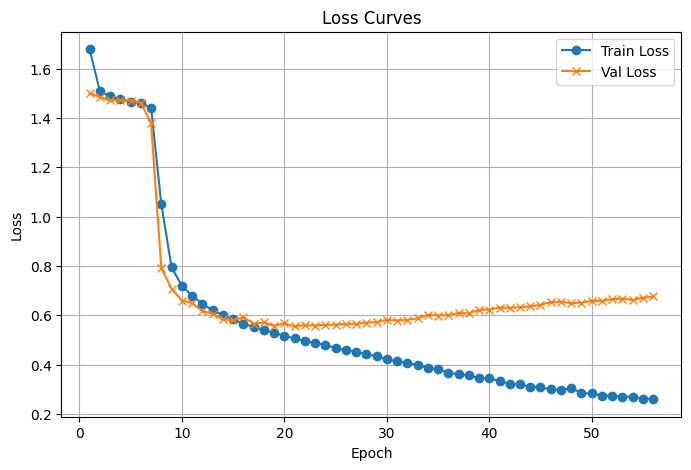

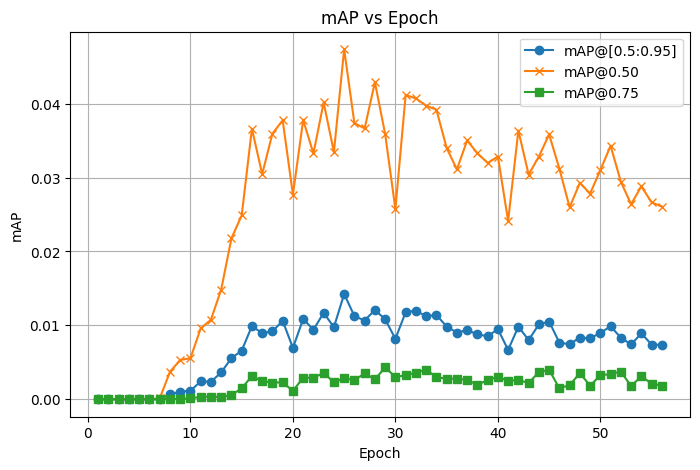

In [59]:
# plotting losses
plot_loss_curves(train_losses_1T, val_losses_1T)

# plotting mAP curves
plot_map_curves(mAPs_1T, mAP50s_1T, mAP75s_1T)



In [60]:
test_image_dir_1T=r"/home/abdullah/YOLO_BTP/RadDet_128_1T/RadDet40k128HW001Tv2/images/test"
test_label_dir_1T=r"/home/abdullah/YOLO_BTP/RadDet_128_1T/RadDet40k128HW001Tv2/labels/test"

In [62]:
# final Evaluation on test set

test_dataset_1T = RadarDataset(test_image_dir_1T, test_label_dir_1T, C=len(class_names))
test_loader_1T = DataLoader(test_dataset_1T, batch_size=8, shuffle=False)

metrics_1T, pr_data, per_class_ap_1T = evaluate(
    model_1T, test_loader_1T,torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    class_names, test_image_dir_1T, test_label_dir_1T
)

print("1T Dataset COCO evaluation metrics:", metrics_1T)
# print("Non-COCO evaluation metrics:", metrics_1T)


# metric1t_conf=evaluate_configurable(model_1T, test_loader_1T,torch.device("cuda" if torch.cuda.is_available() else "cpu"),
#     class_names, test_image_dir_1T, test_label_dir_1T
# )

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate with custom settings
# metrics, pr_data, per_class_ap = evaluate_configurable(
#     model_1T,
#     test_loader_1T,
#     device,
#     class_names,
#     test_image_dir_1T,
#     test_label_dir_1T,
#     conf_thresh=0.1,
#     iou_thresholds=np.arange(0.5, 0.95, 0.05)
# )



Evaluating: 100%|██████████| 2501/2501 [00:27<00:00, 90.21it/s]



Inference Speed: 721.39 FPS
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.57s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.043
 Average Recall     (AR) @[ IoU=0.5

In [32]:

print("\nCalculating Average IoU for TRAINING dataset...")
avg_iou_train = compute_average_iou_for_dataset(model_1T, train_loader_1T, device, iou_threshold=0.5)
print(f"Average IoU (Train, correct detections): {avg_iou_train:.4f}")

print("\nCalculating Average IoU for TEST dataset...")
avg_iou_test = compute_average_iou_for_dataset(model_1T, test_loader_1T, device, iou_threshold=0.5)
print(f"Average IoU (Test, correct detections): {avg_iou_test:.4f}")



Calculating Average IoU for TRAINING dataset...


Computing Avg IoU: 100%|██████████| 1751/1751 [00:26<00:00, 66.53it/s]


Average IoU (Train, correct detections): 0.6670

Calculating Average IoU for TEST dataset...


Computing Avg IoU: 100%|██████████| 2501/2501 [00:35<00:00, 71.27it/s]


Average IoU (Test, correct detections): 0.6440


Final mAP Results: {'mAP': np.float64(0.007892448588526682), 'mAP50': np.float64(0.029143140134528473), 'mAP75': np.float64(0.0012816686415885602), 'AvgIoU': 0.6405155811765654, 'area_mAPs': {'all': {'mAP@0.5': np.float64(0.029143140134528473), 'mAP@0.75': np.float64(0.0012816686415885602)}, 'small': {'mAP@0.5': np.float64(0.0257903409908985), 'mAP@0.75': np.float64(0.0011279514311932353)}, 'medium': {'mAP@0.5': np.float64(0.4882520892431022), 'mAP@0.75': np.float64(0.05211681179640967)}, 'large': {'mAP@0.5': 0.0, 'mAP@0.75': 0.0}}}


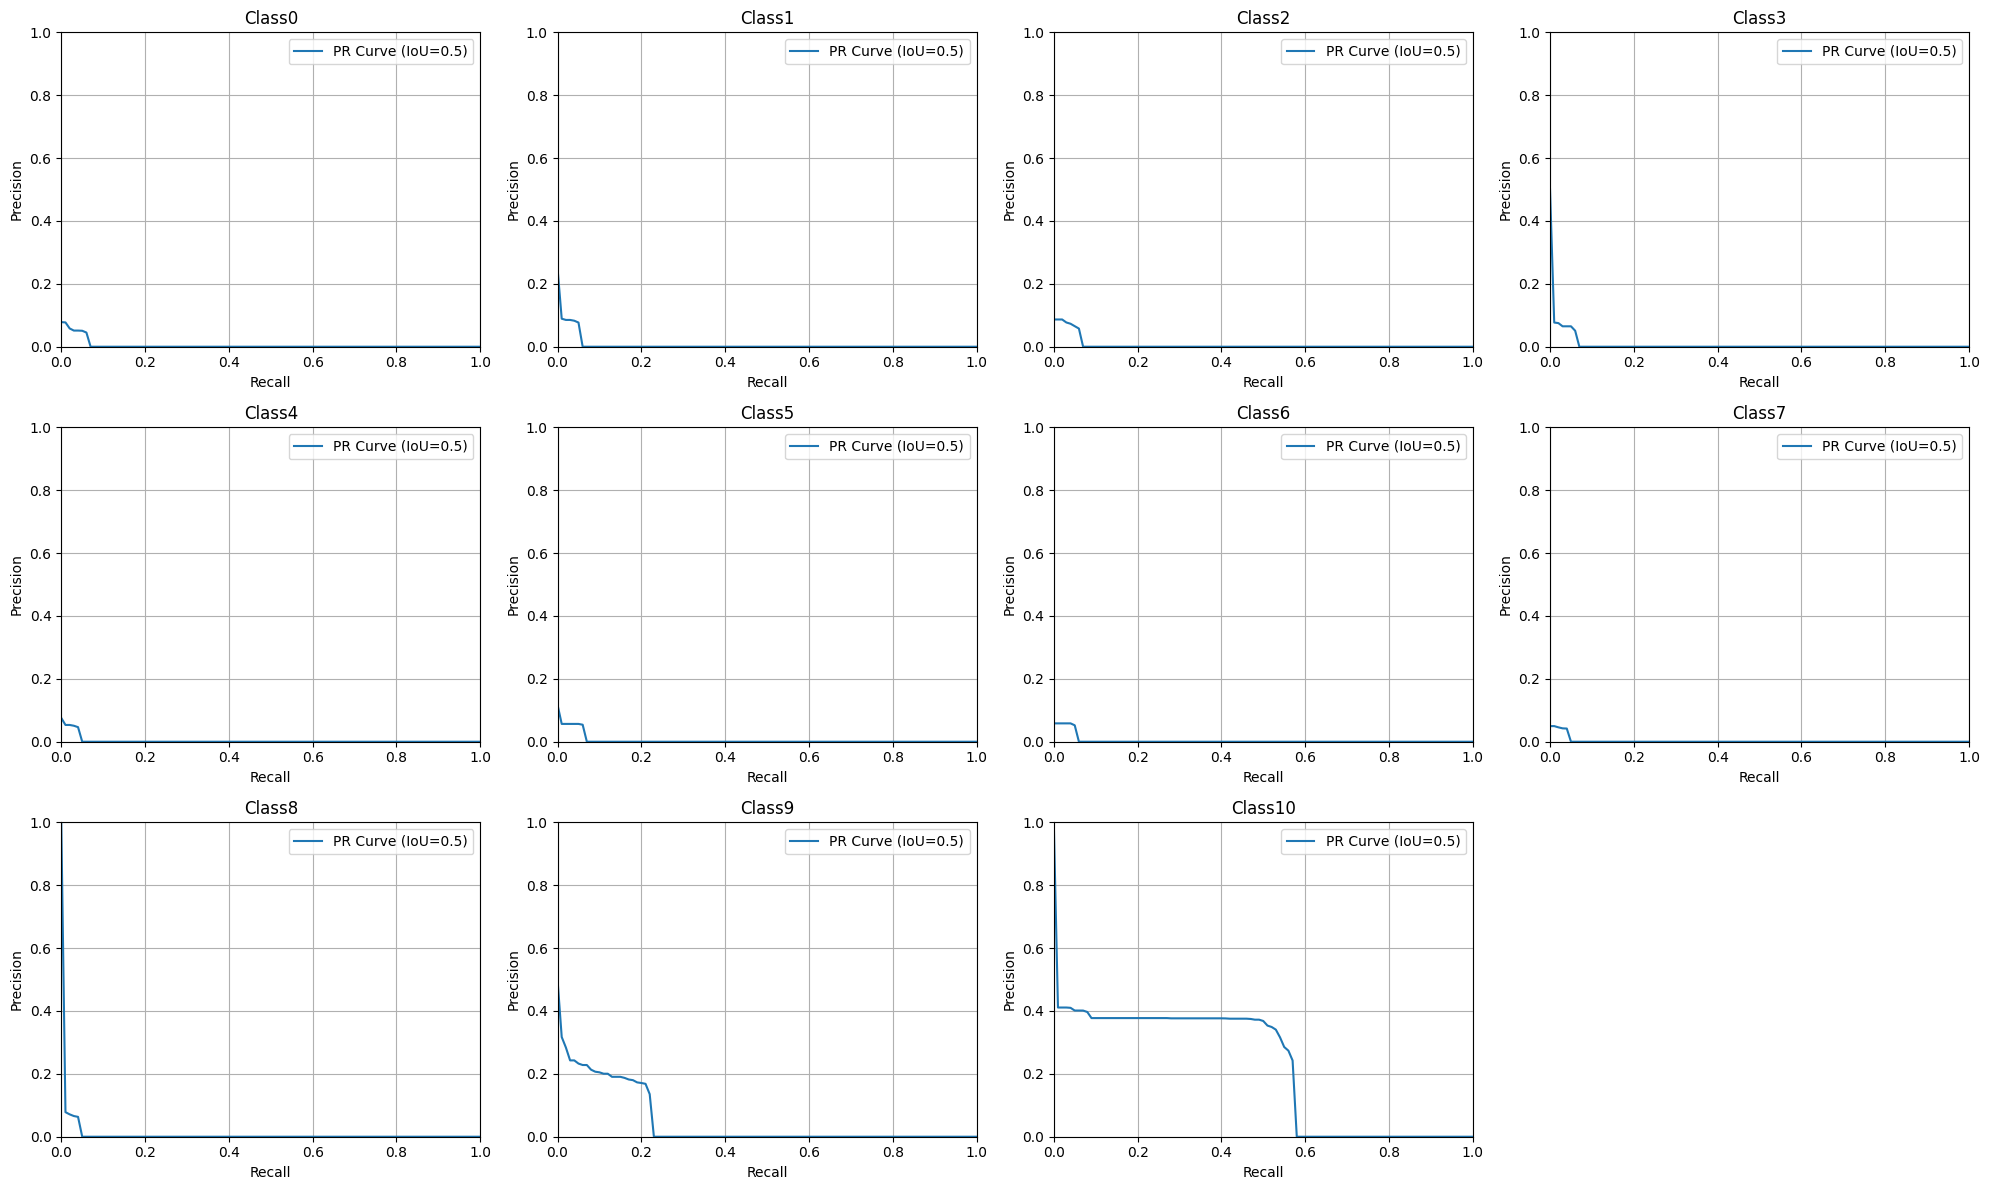

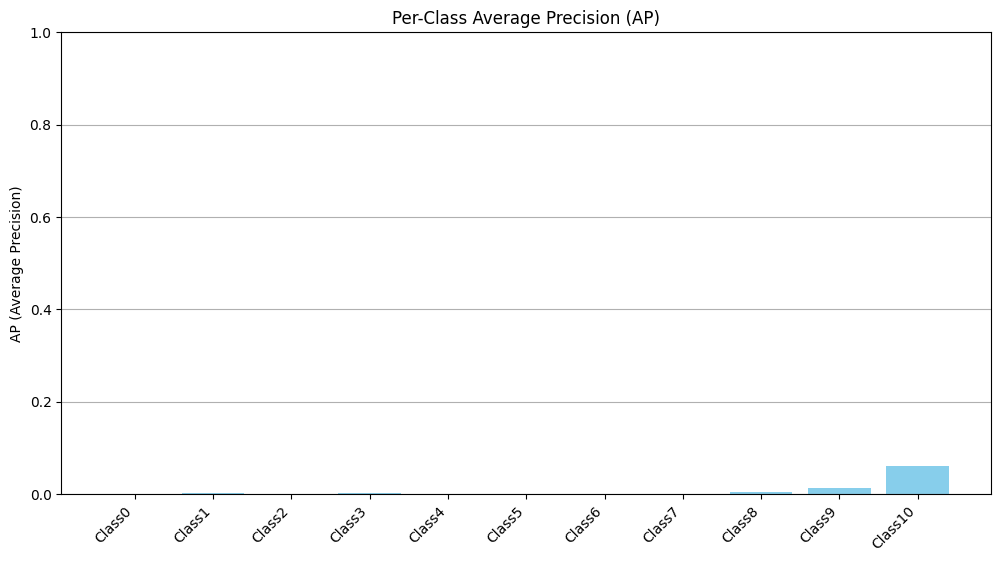

In [33]:
print("Final mAP Results:", metrics_1T)
if pr_data:
    precisions, recalls = pr_data
    plot_pr_curves(precisions, recalls, class_names, iou_thr_idx=0)  # PR curves
if per_class_ap_1T:
    plot_per_class_ap(per_class_ap_1T)  # Per-class AP bar chart

In [ ]:
iou_list, map_values = plot_map_vs_iou(
    model_1T,
    test_loader_1T,
    device,
    class_names,
    test_image_dir_1T,
    test_label_dir_1T,
    conf_thresh=0.1
)
